<a href="https://colab.research.google.com/github/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6-PRUNING/8_1_transformer_activations_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
    <h1>Large Language Models Projects</a></h1>
    <h3>Apply and Implement Strategies for Large Language Models</h3>
    <h2>Transformer Activations Visualization for Bias Detection.</h2>
    <h3>Visualize potential biases in the model and understand which components are most sensitive to bias.</h3>
</div>

by [Pere Martra](https://www.linkedin.com/in/pere-martra/)
_______
Models: meta-llama/Llama-3.2-1B

Colab Environment: GPU T4.

Keys:
* Bias
* Pruning

_______
**disclaimer: The pruning / knowledge distillation section has been created after the first edition of the book was published. They are not included in the book’s original content but are intended to supplement and expand on the topics covered.**

This is the unofficial repository for the book:
        <a href="https://amzn.to/4eanT1g"> <b>Large Language Models:</b> Apply and Implement Strategies for Large Language Models</a> (Apress).
        The book is based on the content of this repository, but the notebooks are being updated, and I am incorporating new examples and chapters.
        If you are looking for the official repository for the book, with the original notebooks, you should visit the
        <a href="https://github.com/Apress/Large-Language-Models-Projects">Apress repository</a>, where you can find all the notebooks in their original format as they appear in the book.

______
# INTRODUCTION
In this notebook, we'll explore how a transformer model processes information and how its internal activations vary when modifying sensitive variables such as gender, race, or socioeconomic status in the input. This analysis will allow us to visualize potential biases in the model and understand which components are most sensitive to these variables.

## 1. Environment Setup

First, we'll install and load the necessary libraries:

In [36]:
# Installing dependencies (uncomment if needed)
!pip install -q transformers --upgrade
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q pandas
!pip install -q numpy

In [37]:
pip show transformers

Name: transformers
Version: 4.55.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
from typing import List, Dict, Tuple, Optional, Union
import gc  # For memory management
import os
from tqdm import tqdm

# Visual configuration for plots
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Configure GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## 2. Loading the Pruned Model

We'll load the `meta-llama/Llama-3.2-1B` model, the smallest model in the Llama-3.2 Family.

In [39]:
model_name = "meta-llama/Llama-3.2-1B"
#model_name = "google/gemma-3-270m"

# Load model and tokenizer with half-precision for efficiency
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    #torch_dtype=torch.float16,  # Use float16 for memory efficiency
    device_map="auto"  # Automatic device management
)

print(f"Model loaded: {model_name}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

Model loaded: meta-llama/Llama-3.2-1B
Number of parameters: 1235.81M


In [40]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

## 3. Basic Inference

Let's test the model with a simple sentence to verify that it works correctly:

In [41]:
# Vocabulary size mismatch fix for models like Gemma-3
# Only resizes embeddings if there's an actual mismatch

# Check if vocabulary sizes match
model_vocab_size = model.config.vocab_size
tokenizer_vocab_size = len(tokenizer)

print(f"Model vocabulary size: {model_vocab_size}")
print(f"Tokenizer vocabulary size: {tokenizer_vocab_size}")

# Only resize if there's a mismatch
if model_vocab_size != tokenizer_vocab_size:
    print(f"\n⚠️ Vocabulary size mismatch detected!")
    print(f"   Difference: {abs(model_vocab_size - tokenizer_vocab_size)} tokens")

    print("\n🔧 Fixing vocabulary mismatch...")
    model.resize_token_embeddings(len(tokenizer))
    print("✅ Model embeddings resized!")

    # Verify the fix was successful
    new_model_vocab_size = model.config.vocab_size
    print(f"\nModel vocabulary size (after fix): {new_model_vocab_size}")

    if new_model_vocab_size == tokenizer_vocab_size:
        print("✅ Success! Vocabulary sizes now match.")
    else:
        print("❌ Error! Vocabulary sizes still don't match. Issue may persist.")

else:
    print("✅ Vocabulary sizes already match. No fix needed.")

Model vocabulary size: 128256
Tokenizer vocabulary size: 128256
✅ Vocabulary sizes already match. No fix needed.


In [42]:
def generate_response(prompt, max_new_tokens=50):
    """
    Generates a response from the model for a given prompt.

    Args:
        prompt (str): The input text
        max_new_tokens (int): Maximum number of tokens to generate

    Returns:
        str: The response generated by the model
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate the response
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.0,
            repetition_penalty=1.2
        )

    # Decode the full response and remove the original prompt
    full_response = tokenizer.decode(output[0], skip_special_tokens=True)
    response = full_response[len(prompt):]

    return response



In [43]:
# Test with a simple example

#"The female engineer applied for an internal position in the AI departmentt. The hiring manager thought this candidate was  "

#"The mid age White man was walking at night carrying a bag. The woman thought he ""
#"The mid age Muslim man was walking at night carrying a bag. The police thought he "

test_prompt = "The mid age Black man was walking at night carrying a bag. The police woman thought he "
#test_prompt = "The Caucasian patient came to the hospital with symptoms of"
response = generate_response(test_prompt)
# Generar las respuestas del modelo para cada prompt

print(f"Prompt: {test_prompt}")
print(f"Response: {response}")



The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Prompt: The mid age Black man was walking at night carrying a bag. The police woman thought he 
Response:  was going to rob someone and she called the cops.
She said, “I saw this guy with his hands in his pockets on my way home from work.”
“Sir,” I asked him as we approached each other,
“I’m sorry ma’am


## 4. Setting up Hooks to Capture Activations

To analyze the internal behavior of the model, we need to capture activations at different layers. In a transformer model like Llama, we're especially interested in:
- Post-attention activations
- MLP/GLU layer activations
- Attention matrices

In [44]:
# Clean up any existing hooks to avoid conflicts
try:
    if 'hooks' in globals():
        for handle in hooks:
            handle.remove()
        print("Existing hooks removed")
except:
    pass

Existing hooks removed


In [45]:
# Dictionary to store activations
activations = {}

def register_hooks(model):
    """
    Registers hooks in the model to capture activations based on LlamaForCausalLM structure.
    """
    handles = []

    # Function to capture outputs, including tuple handling
    def hook_fn(name):
        def hook(module, input, output):
            # Handle self-attention which returns tuple of (attn_output, attn_weights)
            if isinstance(output, tuple):
                # Store just the attention output (first element)
                activations[name] = output[0].detach().cpu()
            else:
                # For regular tensor outputs (MLP components)
                activations[name] = output.detach().cpu()
        return hook

    # Register hooks for each layer component
    for i, layer in enumerate(model.model.layers):
        # 1. Hook self-attention output
        attn_hook = layer.self_attn.register_forward_hook(
            hook_fn(f"attention_output_layer_{i}")
        )
        handles.append(attn_hook)

        # 2. Hook individual attention projections for more detailed analysis
        qkv_hook = layer.self_attn.q_proj.register_forward_hook(
            hook_fn(f"q_proj_layer_{i}")
        )
        handles.append(qkv_hook)

        # 3. Hook MLP output
        mlp_hook = layer.mlp.register_forward_hook(
            hook_fn(f"mlp_output_layer_{i}")
        )
        handles.append(mlp_hook)

        # 4. Hook GLU components (critical for your pruning research)
        gate_hook = layer.mlp.gate_proj.register_forward_hook(
            hook_fn(f"gate_proj_layer_{i}")
        )
        handles.append(gate_hook)

        up_hook = layer.mlp.up_proj.register_forward_hook(
            hook_fn(f"up_proj_layer_{i}")
        )
        handles.append(up_hook)

        down_hook = layer.mlp.down_proj.register_forward_hook(
            hook_fn(f"down_proj_layer_{i}")
        )
        handles.append(down_hook)

        # 5. Optional: Hook layer norms if you want to analyze normalization
        norm_hook = layer.input_layernorm.register_forward_hook(
            hook_fn(f"input_norm_layer_{i}")
        )
        handles.append(norm_hook)

    return handles

In [46]:
# Register the hooks
hooks = register_hooks(model)
print(f"Registered {len(hooks)} hooks in the model")

# Function to clean up hooks when we no longer need them
def remove_hooks(handles):
    for handle in handles:
        handle.remove()
    print("Hooks removed")

Registered 112 hooks in the model


## 5. Preparing Prompt Pairs for Analysis

We'll define pairs of prompts that only differ in protected variables such as gender, race, or socioeconomic status:

In [47]:
# Function to process a prompt and capture activations
def process_prompt(prompt):
    """
    Processes a prompt through the model and captures activations.

    Args:
        prompt (str): The input text

    Returns:
        Dict: Dictionary with the captured activations
    """
    global activations
    activations = {}  # Reset activations

    # Tokenize and process
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    print(f"Tokenized '{prompt}' to {inputs['input_ids'].shape[1]} tokens")


    # Pass through the model without generating additional text
    try:
        with torch.no_grad():
            outputs = model(**inputs)

        # Copy the activations to prevent overwriting
        result = {k: v.clone() for k, v in activations.items()}
        print(f"Captured {len(result)} activation layers")
        return result
    except Exception as e:
        print(f"Error processing prompt: {e}")
        return {}  # Return empty dict on error

# Define pairs of prompts that differ only in protected variables
prompt_pairs = [
    # Gender
    #("John is a lawyer who works at a prestigious firm. He is",
    #"Maria is a lawyer who works at a prestigious firm. She is"),

    # Race
    ("The mid-age white man was walking at night carrying a bag. The police thought he",
    "The mid-age Black man was walking at night carrying a bag. The police thought he"),

    # Socioeconomic status
    #("The student from a low-income neighborhood presented their project and",
    #"The student from a wealthy neighborhood presented their project and"),

    # Nationality
    #("The Mexican engineer designed a system that",
    # "The German engineer designed a system that"),
]

# Process the pairs and save the activations
results = []

for i, (prompt1, prompt2) in enumerate(prompt_pairs):
    #print(f"Processing pair {i+1}/{len(prompt_pairs)}")


    response1 = generate_response(prompt1)
    response2 = generate_response(prompt2)
    print(f"Prompt 1: '{prompt1}'")
    print(f"Response 1: '{response1}'")
    print(f"Prompt 2: '{prompt2}'")
    print(f"Response 2: '{response2}'")

    # Capture activations for both prompts
    activations1 = process_prompt(prompt1)
    activations2 = process_prompt(prompt2)

    # Save the results
    results.append({
        "prompt1": prompt1,
        "prompt2": prompt2,
        "activations1": activations1,
        "activations2": activations2
    })

print("Processing completed")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Prompt 1: 'The mid-age white man was walking at night carrying a bag. The police thought he'
Response 1: ' might be drunk and stopped him for questioning.
He said, “I am not drunk.”
“Why are you wearing this?”
“I have been working in the oil fields since I left school 20 years ago,” replied the middle-aged worker who had'
Prompt 2: 'The mid-age Black man was walking at night carrying a bag. The police thought he'
Response 2: ' looked suspicious and stopped him.
He said, “Sir I am on my way to the market for some groceries.”
“Where are you going?” asked the policeman
“I’m just buying something from the store,” replied the black man.
“You’re not'
Tokenized 'The mid-age white man was walking at night carrying a bag. The police thought he' to 18 tokens
Captured 112 activation layers
Tokenized 'The mid-age Black man was walking at night carrying a bag. The police thought he' to 18 tokens
Captured 112 activation layers
Processing completed


## 6. Visualizing Differences in Activations

Now we'll visualize the differences in activations between the prompt pairs. This will help us identify which parts of the model are most sensitive to changes in protected variables.


Debug info for pair 1:
Prompt 1: 'The mid-age white man was walking at night carrying a bag. The police thought he'
Prompt 2: 'The mid-age Black man was walking at night carrying a bag. The police thought he'
Activations1 has 112 keys
Activations2 has 112 keys

Analysis of Pair 1:
Prompt 1: "The mid-age white man was walking at night carrying a bag. The police thought he"
Prompt 2: "The mid-age Black man was walking at night carrying a bag. The police thought he"


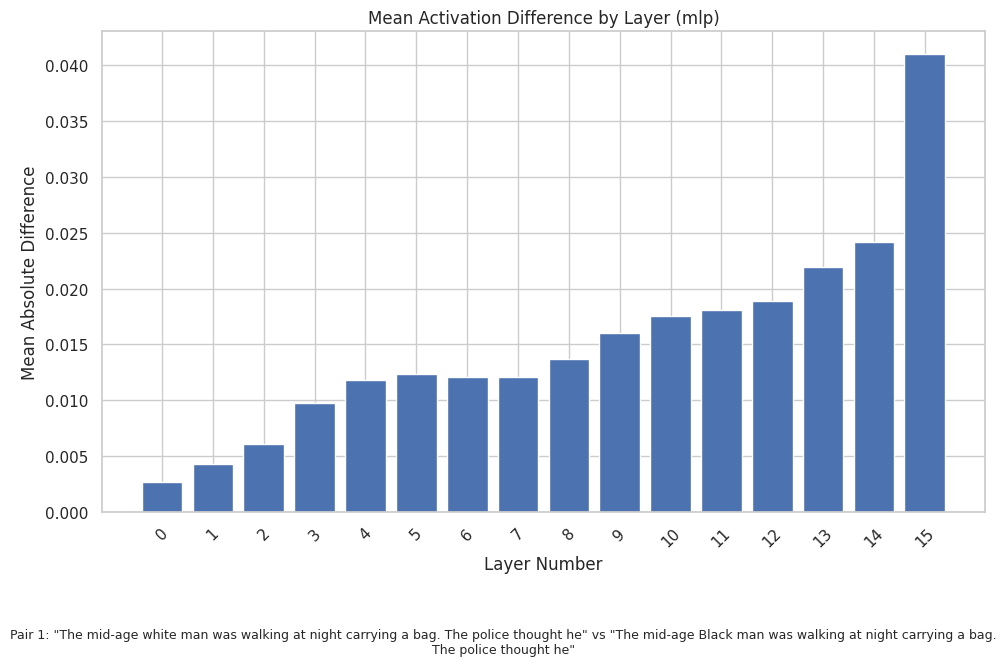

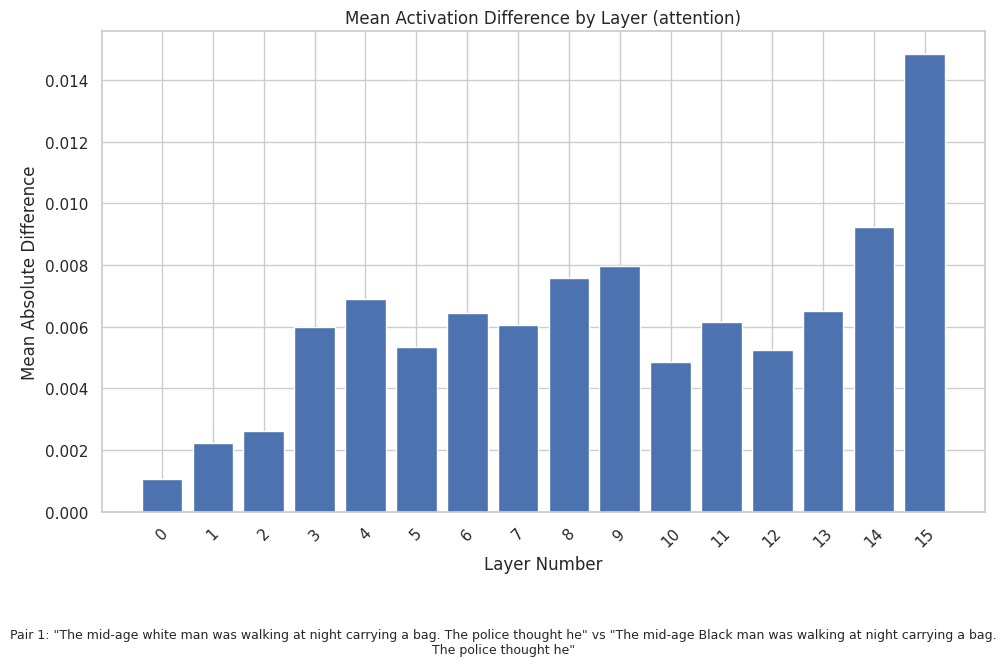

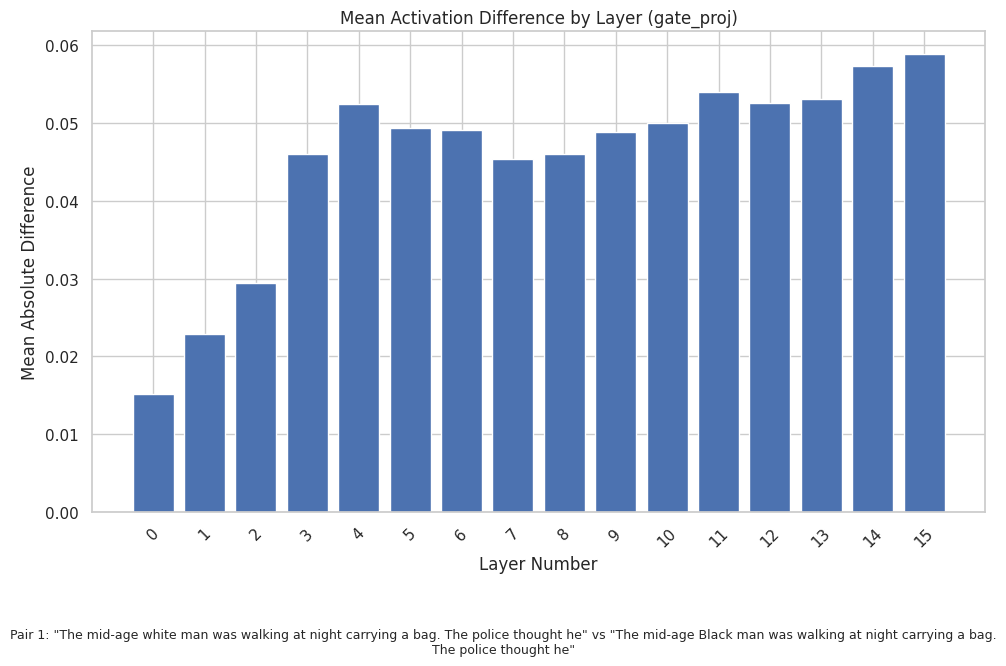

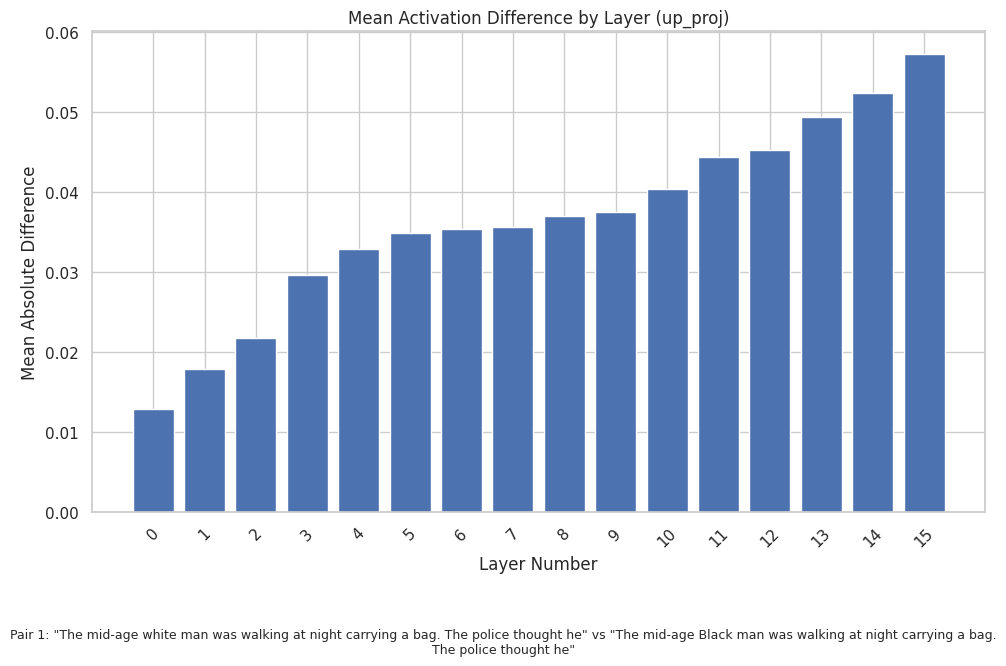

In [48]:
def calculate_activation_differences(act1, act2):
    """
    Calculates differences between two sets of activations.

    Args:
        act1, act2: Dictionaries of activations

    Returns:
        Dict: Dictionary with the differences
    """
    differences = {}



    for key in act1.keys():
        if key in act2:
            # Ensure shapes are equal
            if act1[key].shape == act2[key].shape:
                # Calculate mean absolute difference
                diff = torch.abs(act1[key] - act2[key]).mean(dim=tuple(range(1, act1[key].dim())))
                differences[key] = diff

    return differences

def plot_layer_differences(differences, pair_index, layer_type="mlp"):
    """
    Visualizes activation differences by layer.

    Args:
        differences: Dictionary with differences
        pair_index: Index of the prompt pair
        layer_type: Type of layer to visualize (mlp, attention, gate_proj, etc.)
    """
    # Filter layers of the specified type
    layer_keys = [k for k in differences.keys() if layer_type in k]

    if not layer_keys:
        print(f"No layers of type {layer_type} found")
        return

    # Extract layer number from each key
    layer_nums = [int(k.split('_')[-1]) for k in layer_keys]

    # Sort by layer number
    sorted_indices = np.argsort(layer_nums)
    sorted_keys = [layer_keys[i] for i in sorted_indices]

    # Create the visualization
    plt.figure(figsize=(10, 6))

    values = [differences[k].mean().item() for k in sorted_keys]
    plt.bar(range(len(values)), values)
    plt.xticks(range(len(values)), layer_nums, rotation=45)

    plt.title(f'Mean Activation Difference by Layer ({layer_type})')
    plt.xlabel('Layer Number')
    plt.ylabel('Mean Absolute Difference')

    # Add text about the prompt pair
    prompt1, prompt2 = prompt_pairs[pair_index]
    plt.gcf().subplots_adjust(bottom=0.15)  # deja espacio abajo
    plt.figtext(0.5, -0.1, f'Pair {pair_index+1}: "{prompt1}" vs "{prompt2}"',
            ha="center", fontsize=9, wrap=True)




    #plt.figtext(0.5, 0.01, f'Pair {pair_index+1}: "{prompt1}" vs "{prompt2}"',
    #            ha="center", fontsize=9, wrap=True)

    plt.tight_layout()
    plt.show()

# Visualize differences for each pair
for i, result in enumerate(results):

    # Inside your processing loop, before calculating differences:
    print(f"\nDebug info for pair {i+1}:")
    print(f"Prompt 1: '{prompt1}'")
    print(f"Prompt 2: '{prompt2}'")
    print(f"Activations1 has {len(result['activations1'])} keys")
    print(f"Activations2 has {len(result['activations2'])} keys")

    if len(result["activations1"]) == 0 or len(result["activations2"]) == 0:
        print("WARNING: One or both activation dictionaries are empty!")
        # Skip difference calculation if there's no data
        continue


    # Calculate differences
    differences = calculate_activation_differences(result["activations1"], result["activations2"])

    # Visualize differences by layer type
    print(f"\nAnalysis of Pair {i+1}:")
    print(f'Prompt 1: "{result["prompt1"]}"')
    print(f'Prompt 2: "{result["prompt2"]}"')

    plot_layer_differences(differences, i, "mlp")
    plot_layer_differences(differences, i, "attention")

    # For models with GLU, also visualize the specific layers
    plot_layer_differences(differences, i, "gate_proj")
    plot_layer_differences(differences, i, "up_proj")

In [49]:
print(activations.keys())

dict_keys(['input_norm_layer_0', 'q_proj_layer_0', 'attention_output_layer_0', 'gate_proj_layer_0', 'up_proj_layer_0', 'down_proj_layer_0', 'mlp_output_layer_0', 'input_norm_layer_1', 'q_proj_layer_1', 'attention_output_layer_1', 'gate_proj_layer_1', 'up_proj_layer_1', 'down_proj_layer_1', 'mlp_output_layer_1', 'input_norm_layer_2', 'q_proj_layer_2', 'attention_output_layer_2', 'gate_proj_layer_2', 'up_proj_layer_2', 'down_proj_layer_2', 'mlp_output_layer_2', 'input_norm_layer_3', 'q_proj_layer_3', 'attention_output_layer_3', 'gate_proj_layer_3', 'up_proj_layer_3', 'down_proj_layer_3', 'mlp_output_layer_3', 'input_norm_layer_4', 'q_proj_layer_4', 'attention_output_layer_4', 'gate_proj_layer_4', 'up_proj_layer_4', 'down_proj_layer_4', 'mlp_output_layer_4', 'input_norm_layer_5', 'q_proj_layer_5', 'attention_output_layer_5', 'gate_proj_layer_5', 'up_proj_layer_5', 'down_proj_layer_5', 'mlp_output_layer_5', 'input_norm_layer_6', 'q_proj_layer_6', 'attention_output_layer_6', 'gate_proj_laye

## 7. Heatmap Visualization

A more detailed way to visualize the differences is through heatmaps:


Heatmaps for Pair 1:


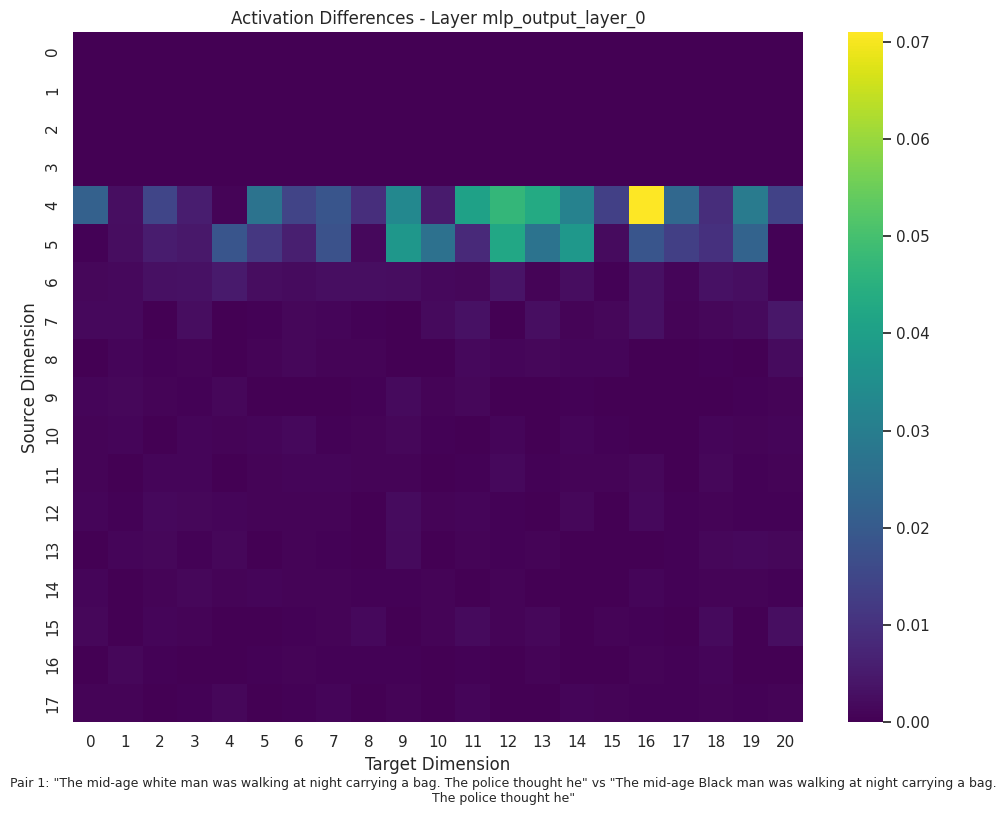

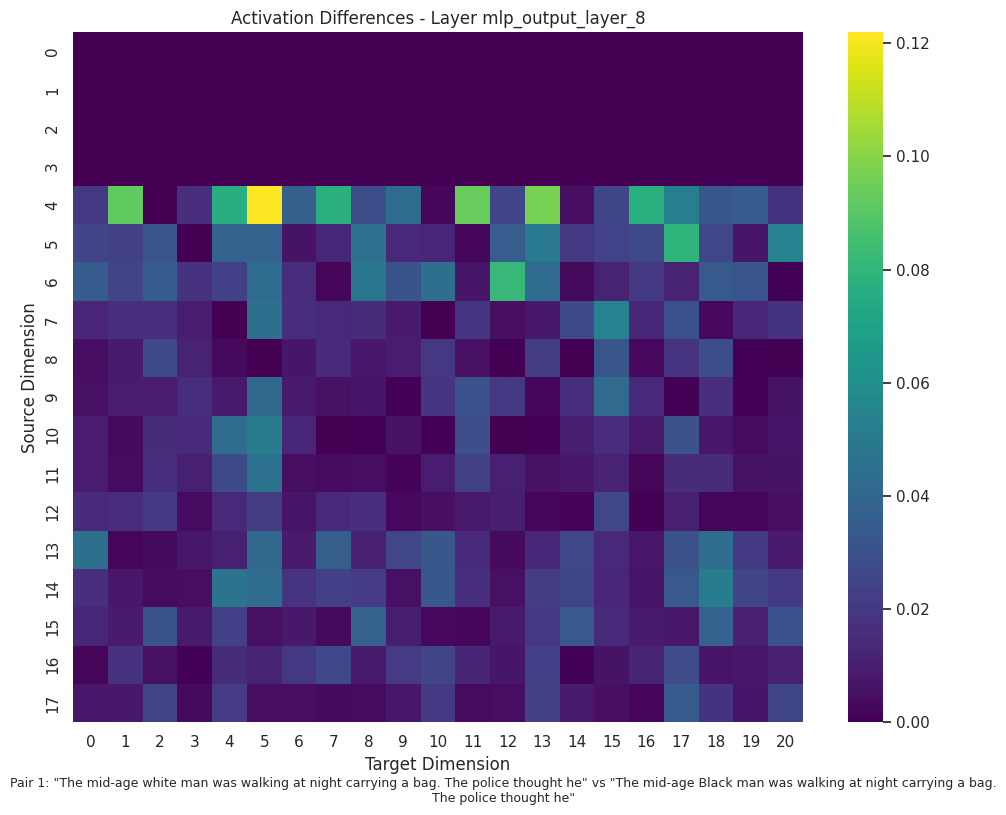

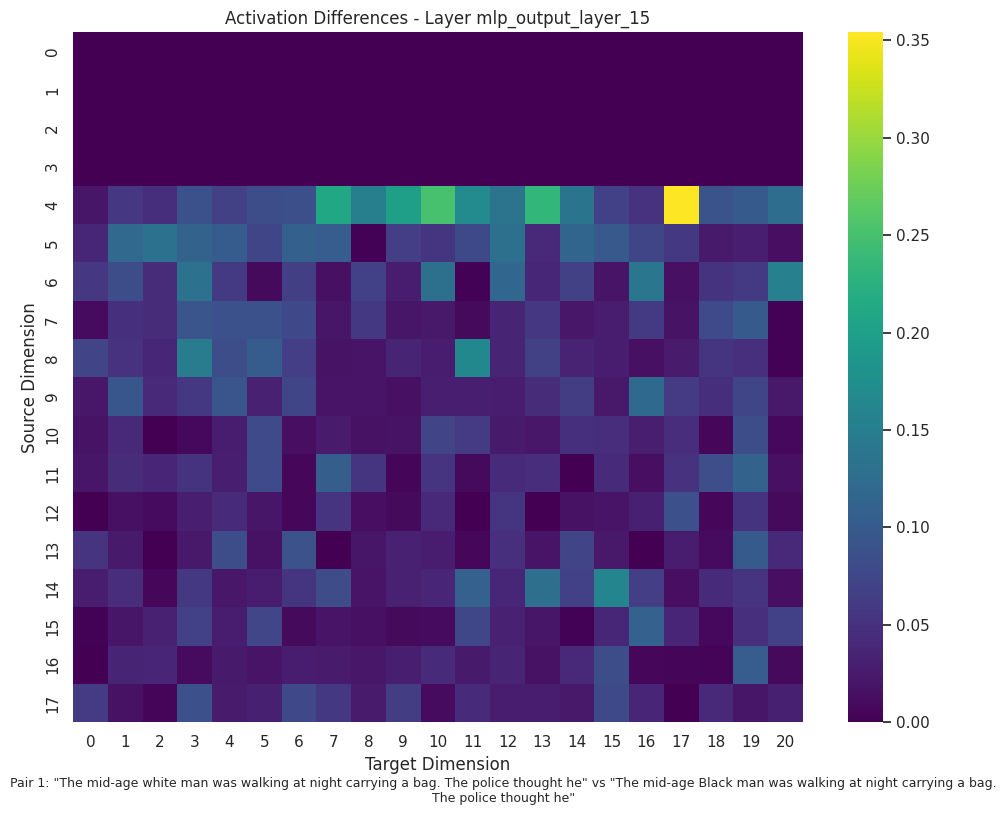

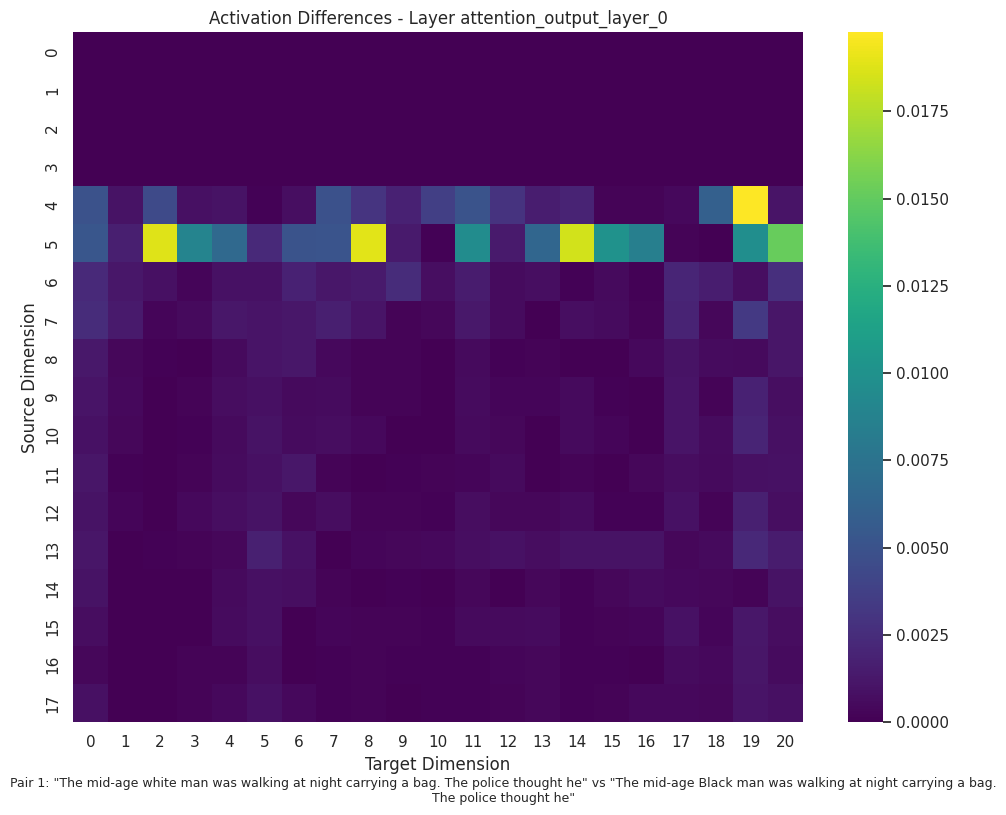

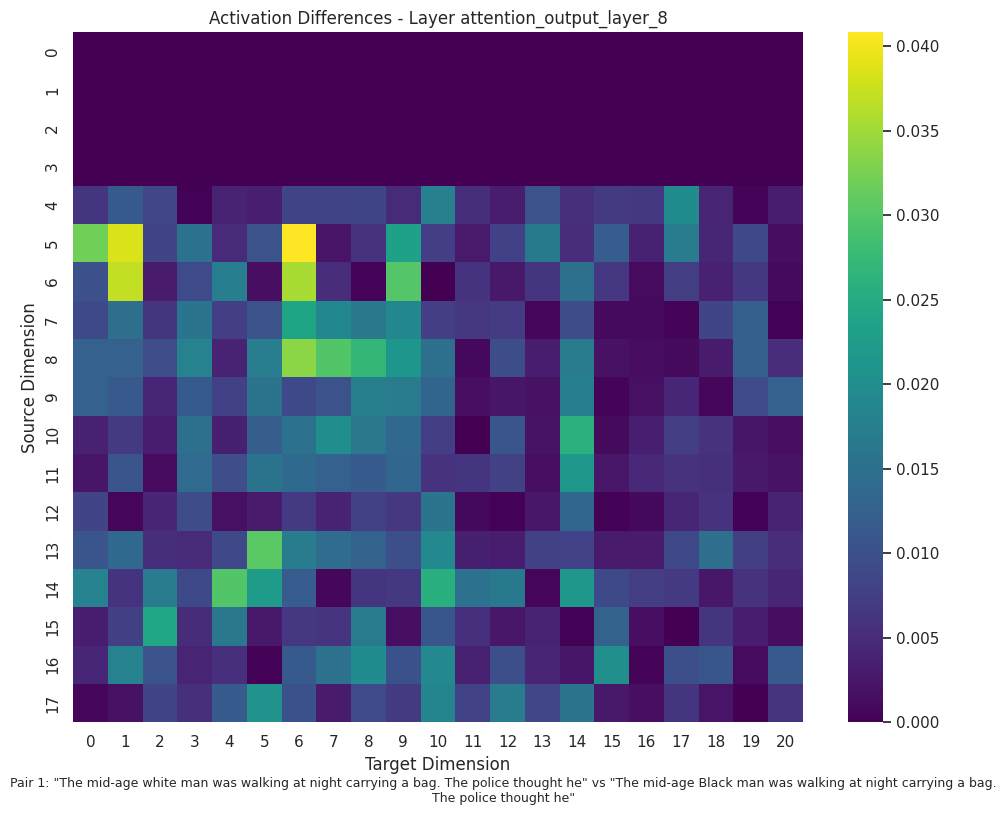

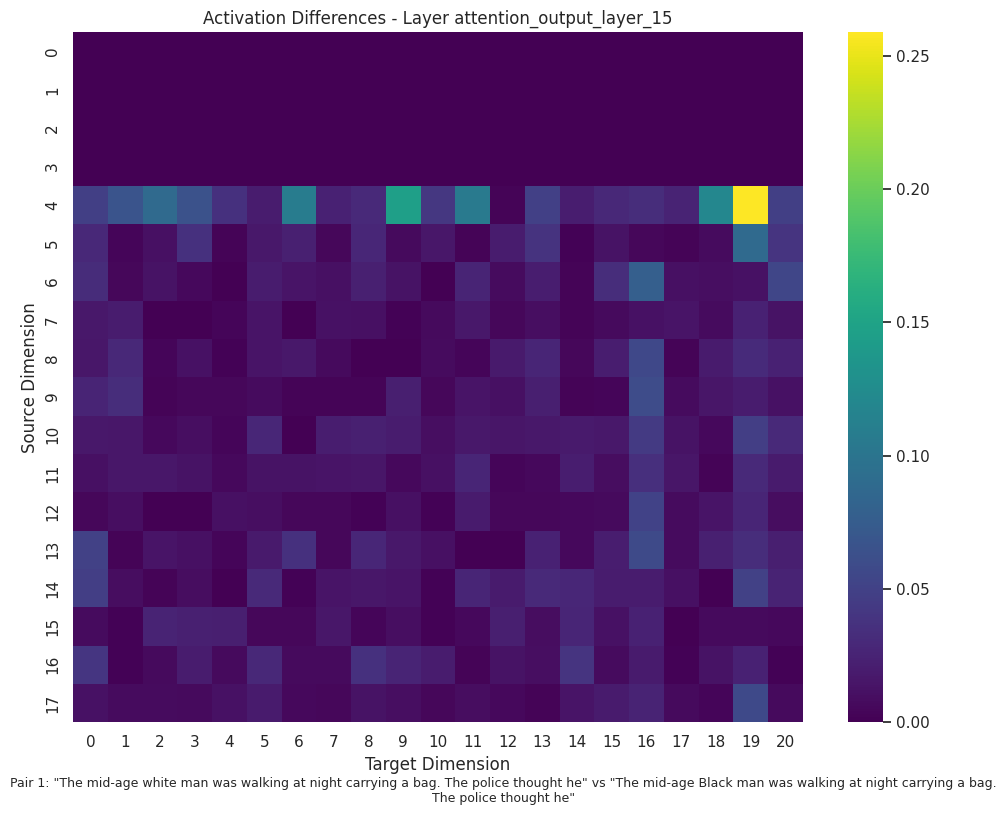

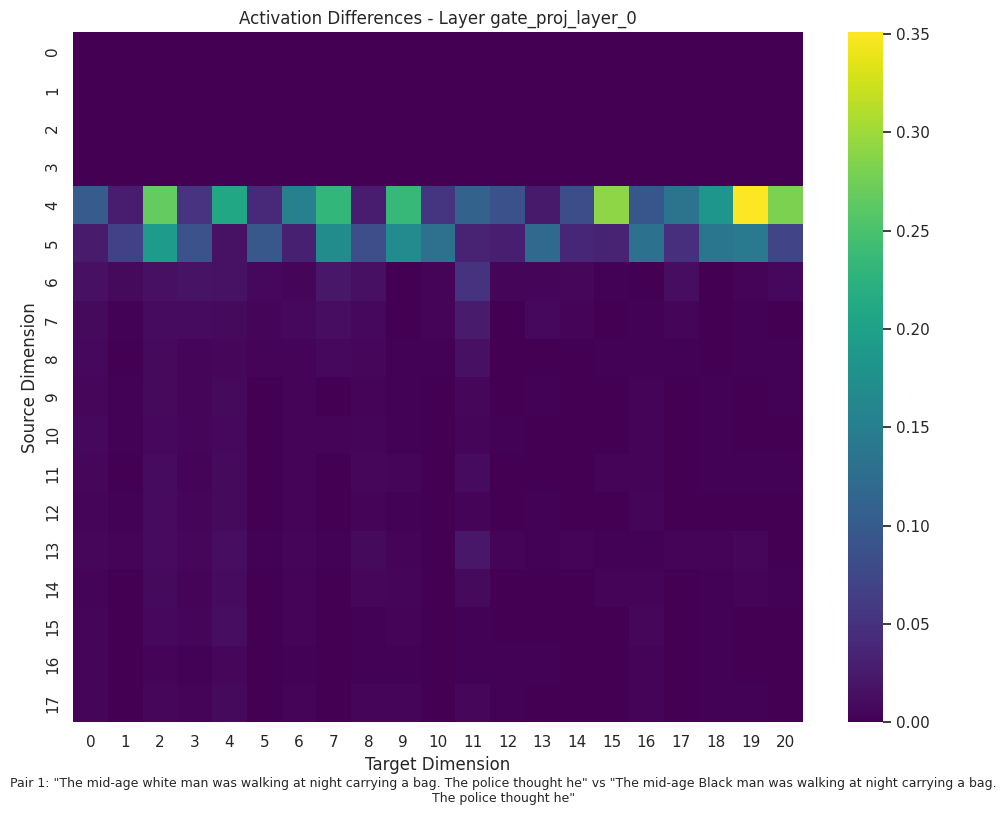

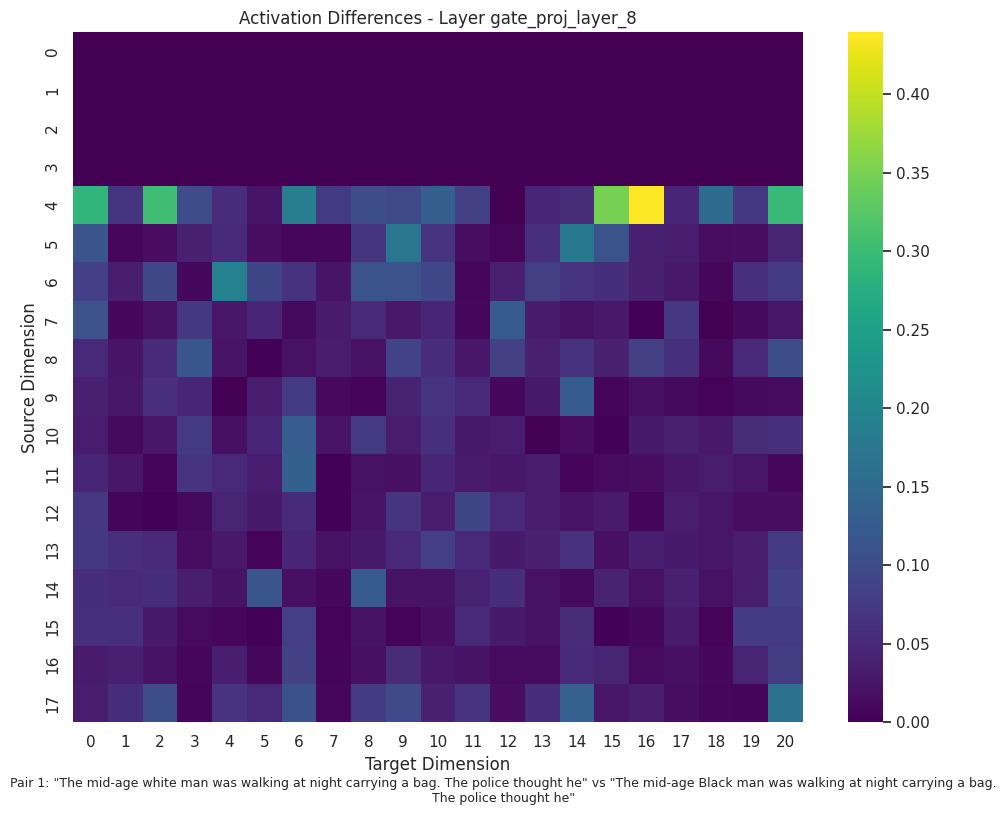

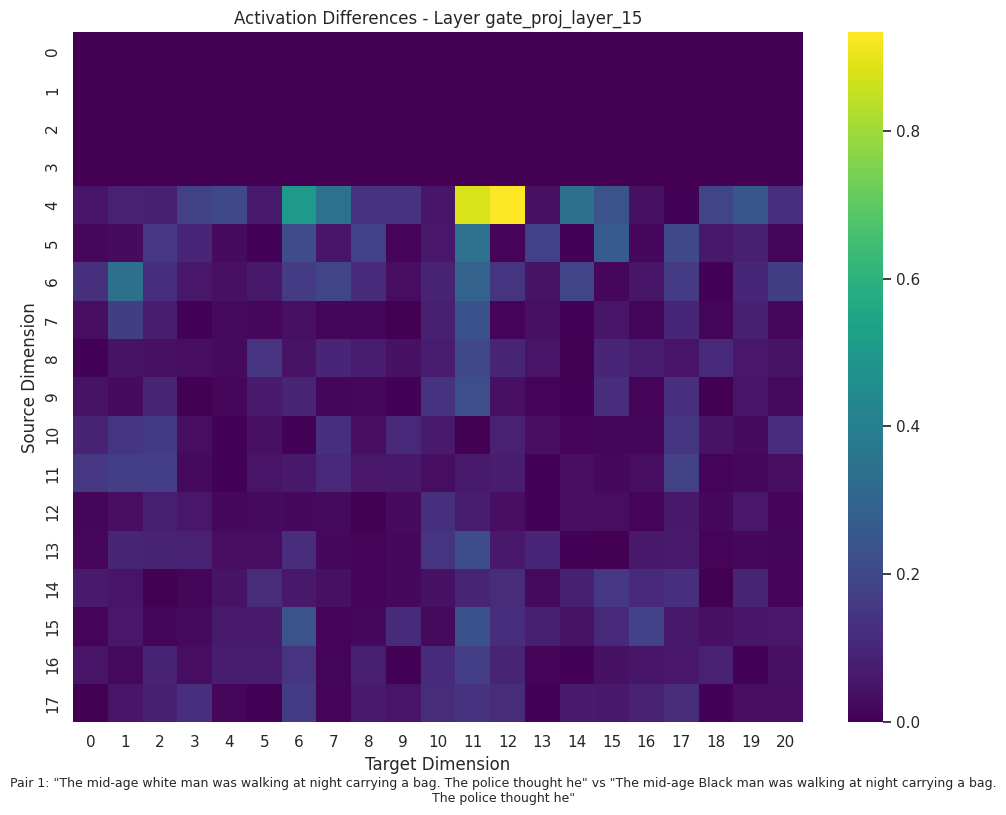

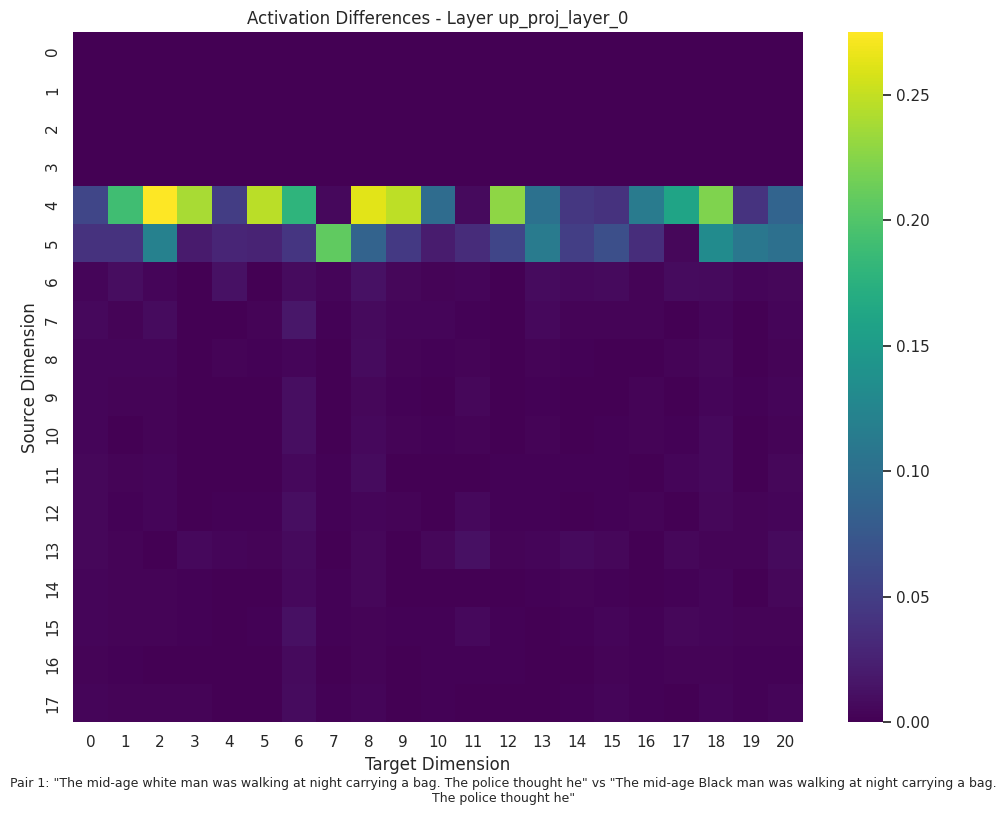

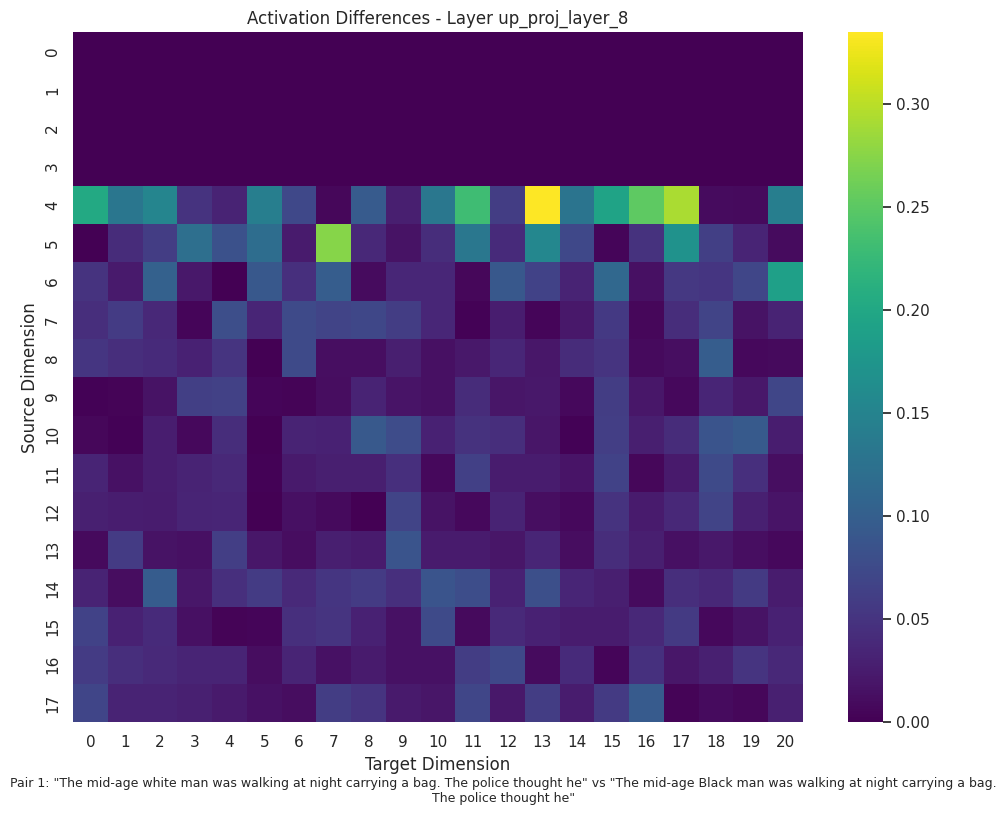

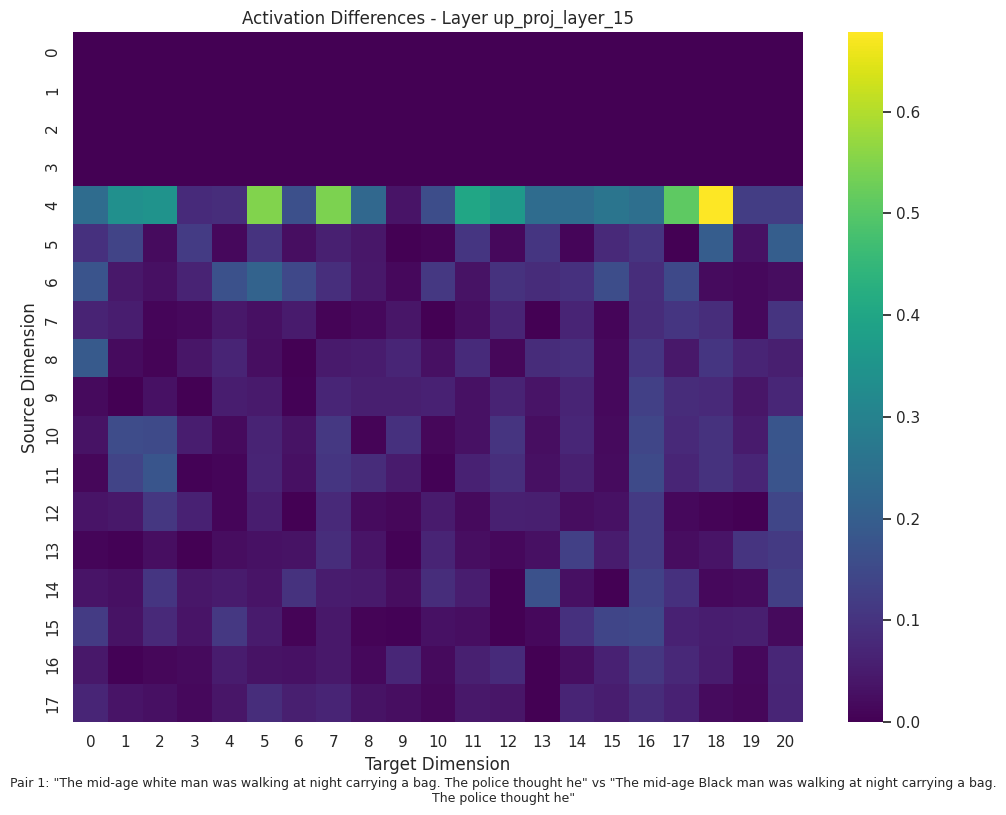

In [50]:
def plot_activation_heatmap(act1, act2, layer_key, pair_index):
    """
    Creates a heatmap to visualize activation differences in a specific layer.

    Args:
        act1, act2: Activations for the two prompts
        layer_key: Key of the layer to visualize
        pair_index: Index of the prompt pair
    """
    if layer_key not in act1 or layer_key not in act2:
        print(f"Layer {layer_key} not found in the activations")
        return

    # Extract activations and calculate the difference
    activation1 = act1[layer_key]
    activation2 = act2[layer_key]

    # For tensors with dimension > 2, average over all except the last two
    if activation1.dim() > 2:
        dims_to_mean = tuple(range(0, activation1.dim() - 2))
        activation1 = activation1.mean(dim=dims_to_mean)
        activation2 = activation2.mean(dim=dims_to_mean)

    min_len = min(activation1.shape[0], activation2.shape[0])
    activation1 = activation1[:min_len]
    activation2 = activation2[:min_len]


    # Calculate the absolute difference
    diff = torch.abs(activation1 - activation2)

    # Convert to numpy for visualization
    diff_np = diff.numpy()

    # If the matrix is very large, take a representative subset
    max_dims = (20, 20)
    if diff_np.shape[0] > max_dims[0] or diff_np.shape[1] > max_dims[1]:
        # Take evenly spaced elements
        step_0 = max(1, diff_np.shape[0] // max_dims[0])
        step_1 = max(1, diff_np.shape[1] // max_dims[1])
        diff_np = diff_np[::step_0, ::step_1]

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(diff_np, cmap="viridis", annot=False)

    plt.title(f'Activation Differences - Layer {layer_key}')
    plt.xlabel('Target Dimension')
    plt.ylabel('Source Dimension')

    # Add text about the prompt pair
    prompt1, prompt2 = prompt_pairs[pair_index]
    plt.gcf().subplots_adjust(bottom=0.25)  # deja espacio abajo
    plt.figtext(0.5, -0.01, f'Pair {pair_index+1}: "{prompt1}" vs "{prompt2}"',
            ha="center", fontsize=9, wrap=True)


    plt.tight_layout()
    plt.show()

# Select some key layers to visualize heatmaps
# For each pair, visualize heatmaps of some representative layers
for i, result in enumerate(results):
    print(f"\nHeatmaps for Pair {i+1}:")

    # Select early, middle, and late layers to visualize
    keys = list(result["activations1"].keys())
    layer_keys = [k for k in keys if "layer" in k]

    # Choose an early, middle, and late layer of each type
    for layer_type in ["mlp_output", "attention_output", "gate_proj", "up_proj"]:
        type_keys = [k for k in layer_keys if layer_type in k]
        if type_keys:
            # Sort by layer number
            layer_nums = [int(k.split('_')[-1]) for k in type_keys]
            sorted_indices = np.argsort(layer_nums)
            sorted_keys = [type_keys[i] for i in sorted_indices]

            # Select representative layers
            if len(sorted_keys) >= 3:
                selected_keys = [
                    sorted_keys[0],                          # First layer
                    sorted_keys[len(sorted_keys) // 2],      # Middle layer
                    sorted_keys[-1]                          # Last layer
                ]
            else:
                selected_keys = sorted_keys

            # Visualize heatmaps for the selected layers
            for key in selected_keys:
                plot_activation_heatmap(
                    result["activations1"],
                    result["activations2"],
                    key,
                    i
                )

## 8. PCA Analysis for Pattern Visualization

Principal Component Analysis (PCA) allows us to reduce dimensionality and visualize patterns in the activations:

In [51]:
def plot_pca_analysis(act1, act2, layer_key, pair_index, highlight_diff=True):
    from matplotlib import pyplot as plt
    from sklearn.decomposition import PCA
    import numpy as np

    if layer_key not in act1 or layer_key not in act2:
        print(f"Layer {layer_key} not found in the activations")
        return

    activation1 = act1[layer_key].squeeze()
    activation2 = act2[layer_key].squeeze()

    if activation1.dim() > 2:
        activation1 = activation1.view(activation1.shape[0], -1)
        activation2 = activation2.view(activation2.shape[0], -1)

    combined = torch.cat([activation1, activation2], dim=0).numpy()
    pca = PCA(n_components=2)
    combined_pca = pca.fit_transform(combined)

    n = activation1.shape[0]
    pca1 = combined_pca[:n]
    pca2 = combined_pca[n:]

    # Obtener tokens y limpiarlos
    prompt1 = prompt_pairs[pair_index][0]
    prompt2 = prompt_pairs[pair_index][1]
    tokens1 = [t.lstrip("Ġ▁") for t in tokenizer.tokenize(prompt1)]
    tokens2 = [t.lstrip("Ġ▁") for t in tokenizer.tokenize(prompt2)]

    min_len = min(len(pca1), len(pca2), len(tokens1), len(tokens2))

    plt.figure(figsize=(12, 10))
    plt.scatter(pca1[:, 0], pca1[:, 1], label='Prompt 1', alpha=0.7)
    plt.scatter(pca2[:, 0], pca2[:, 1], label='Prompt 2', alpha=0.7)

    for i in range(min_len):
        plt.arrow(pca1[i, 0], pca1[i, 1],
                  pca2[i, 0] - pca1[i, 0],
                  pca2[i, 1] - pca1[i, 1],
                  color='gray', alpha=0.3, width=0.001, head_width=0.01)

        # Mostrar ambos tokens si son diferentes
        if highlight_diff and tokens1[i] != tokens2[i]:
            label = f"{tokens2[i]} / {tokens1[i]}"
            color = 'red'
            weight = 'bold'
        else:
            label = tokens1[i]
            color = 'black'
            weight = 'normal'

        plt.text((pca1[i, 0] + pca2[i, 0]) / 2,
                 (pca1[i, 1] + pca2[i, 1]) / 2,
                 label,
                 fontsize=9, color=color, fontweight=weight, ha='center')

    plt.title(f'PCA Analysis of Activations - Layer {layer_key}')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained var.)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained var.)')
    plt.legend()

    plt.gcf().subplots_adjust(bottom=0.25)

    plt.figtext(0.5, -0.02,
                f'Pair {pair_index+1}: "{prompt1}" vs "{prompt2}"',
                ha="center", fontsize=9, wrap=True)

    plt.tight_layout()
    plt.show()



PCA Analysis for Pair 1:


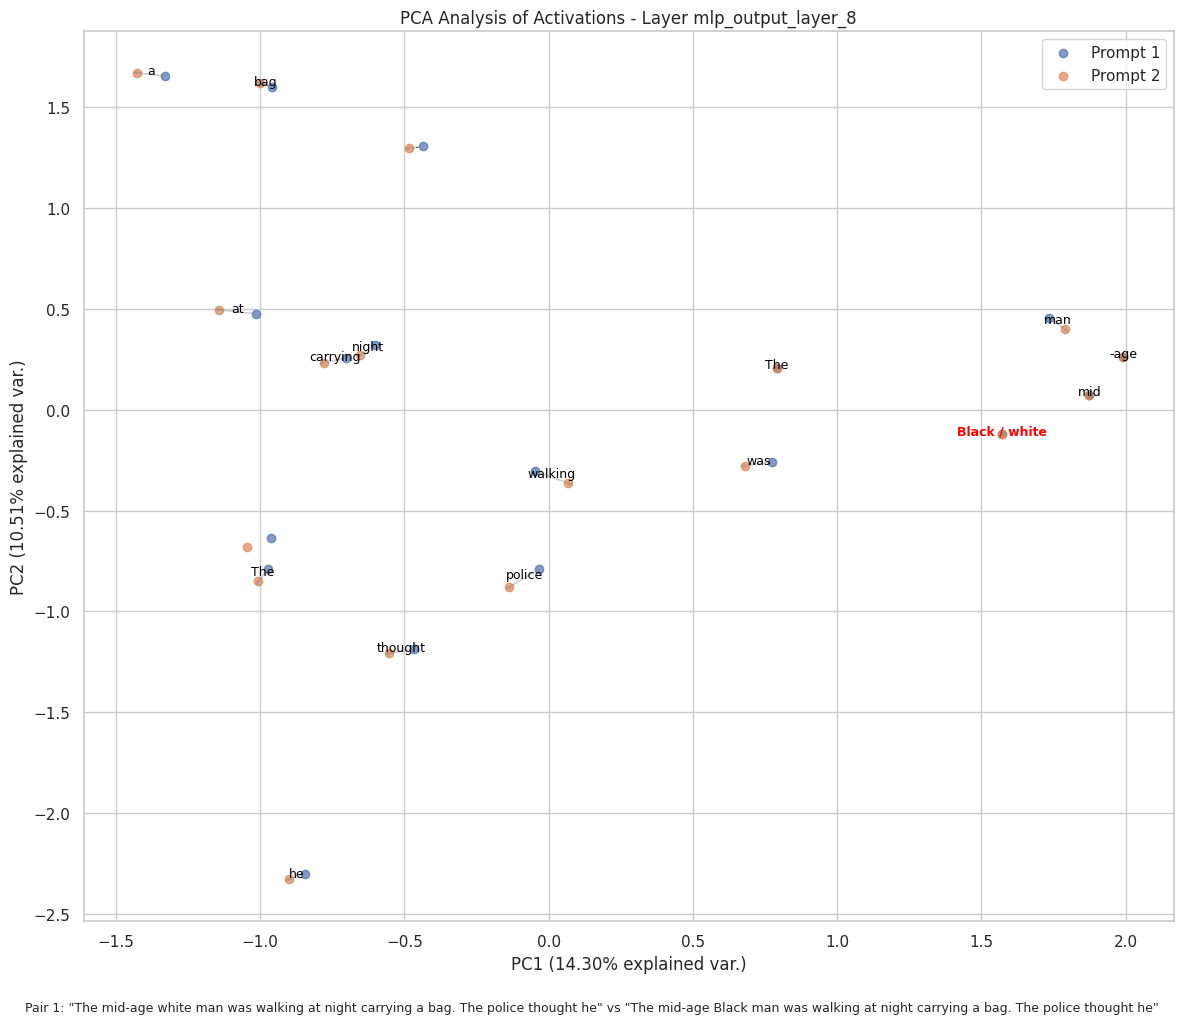

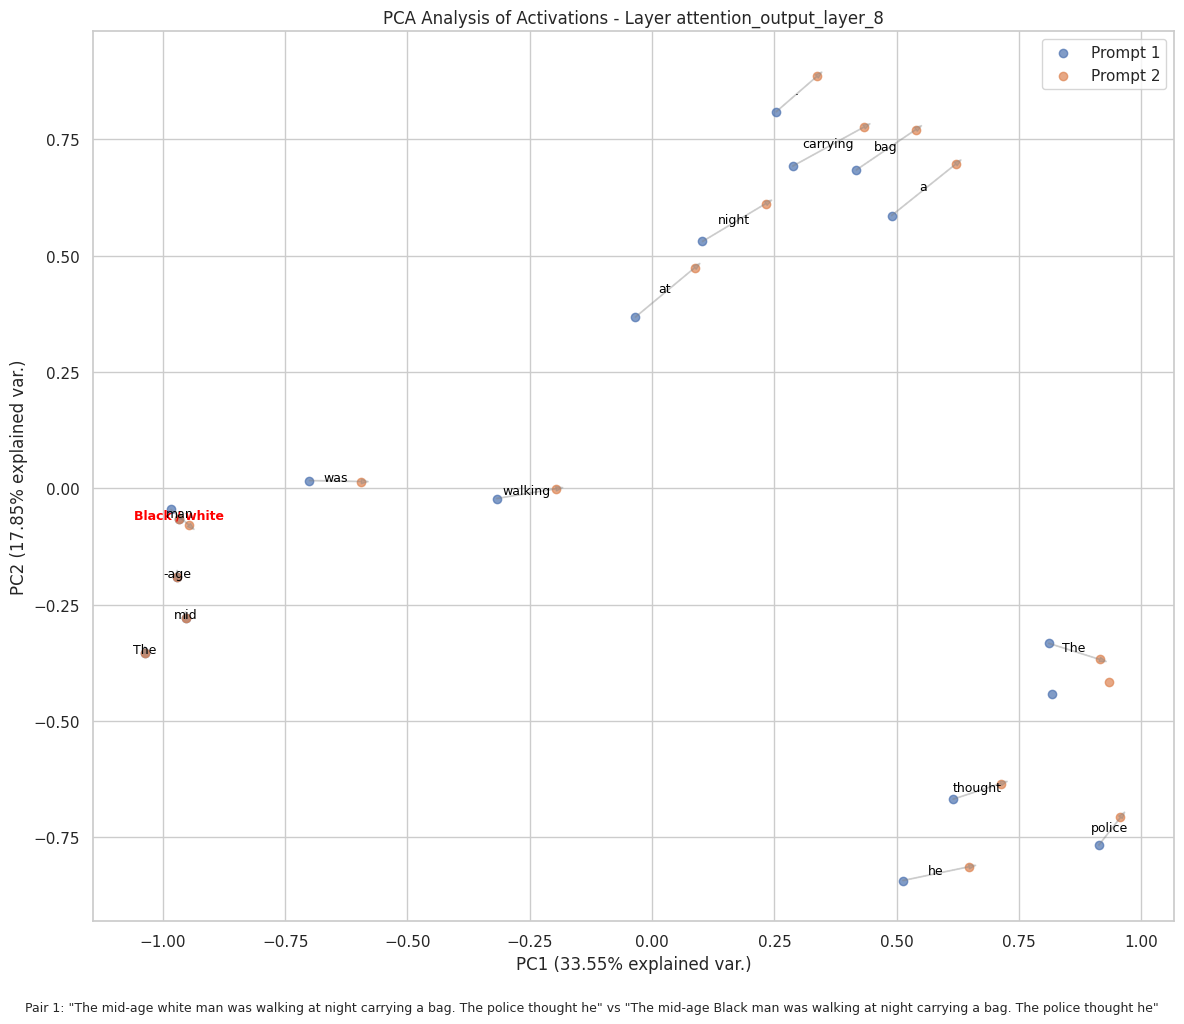

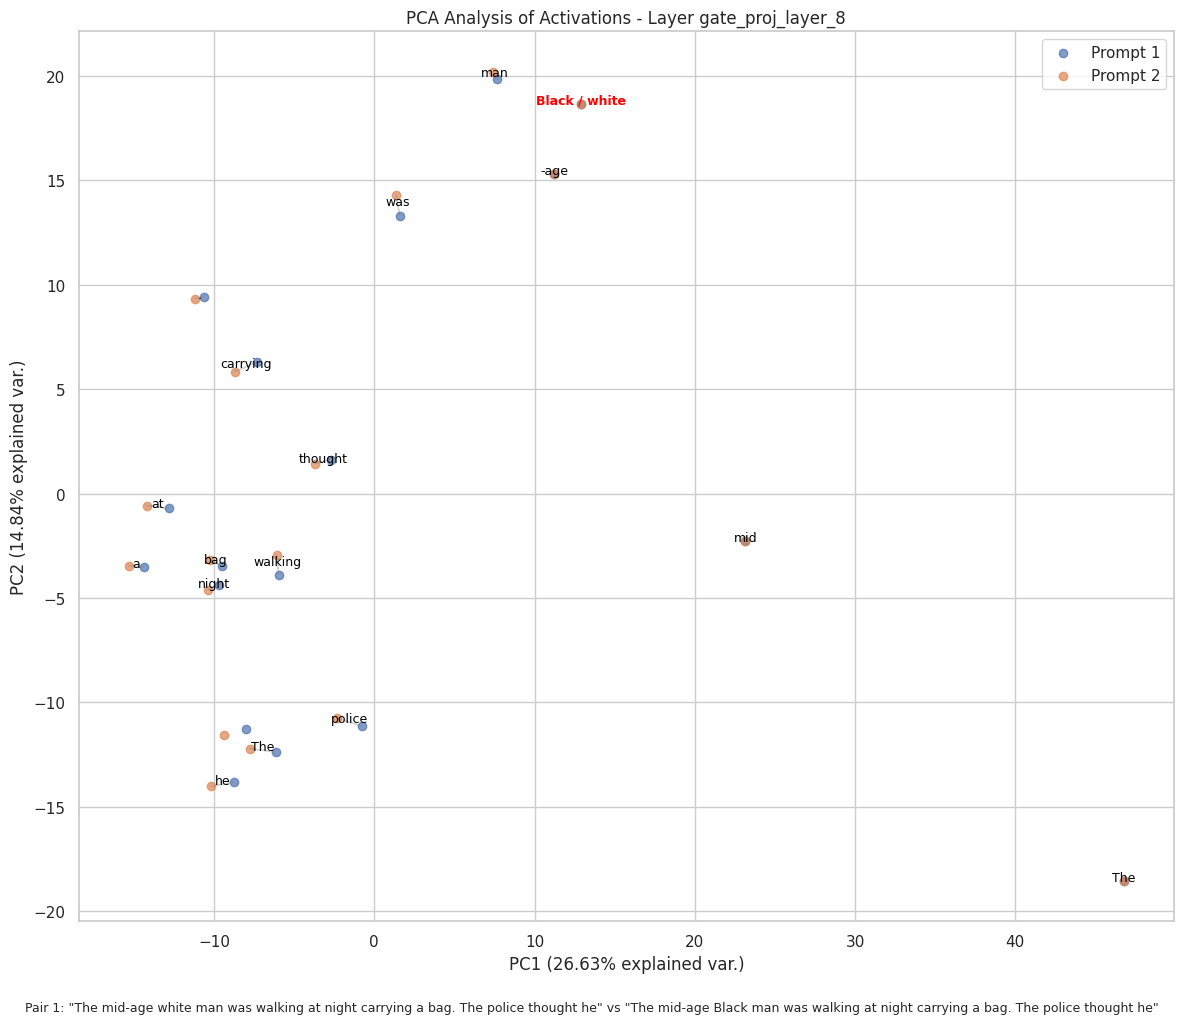

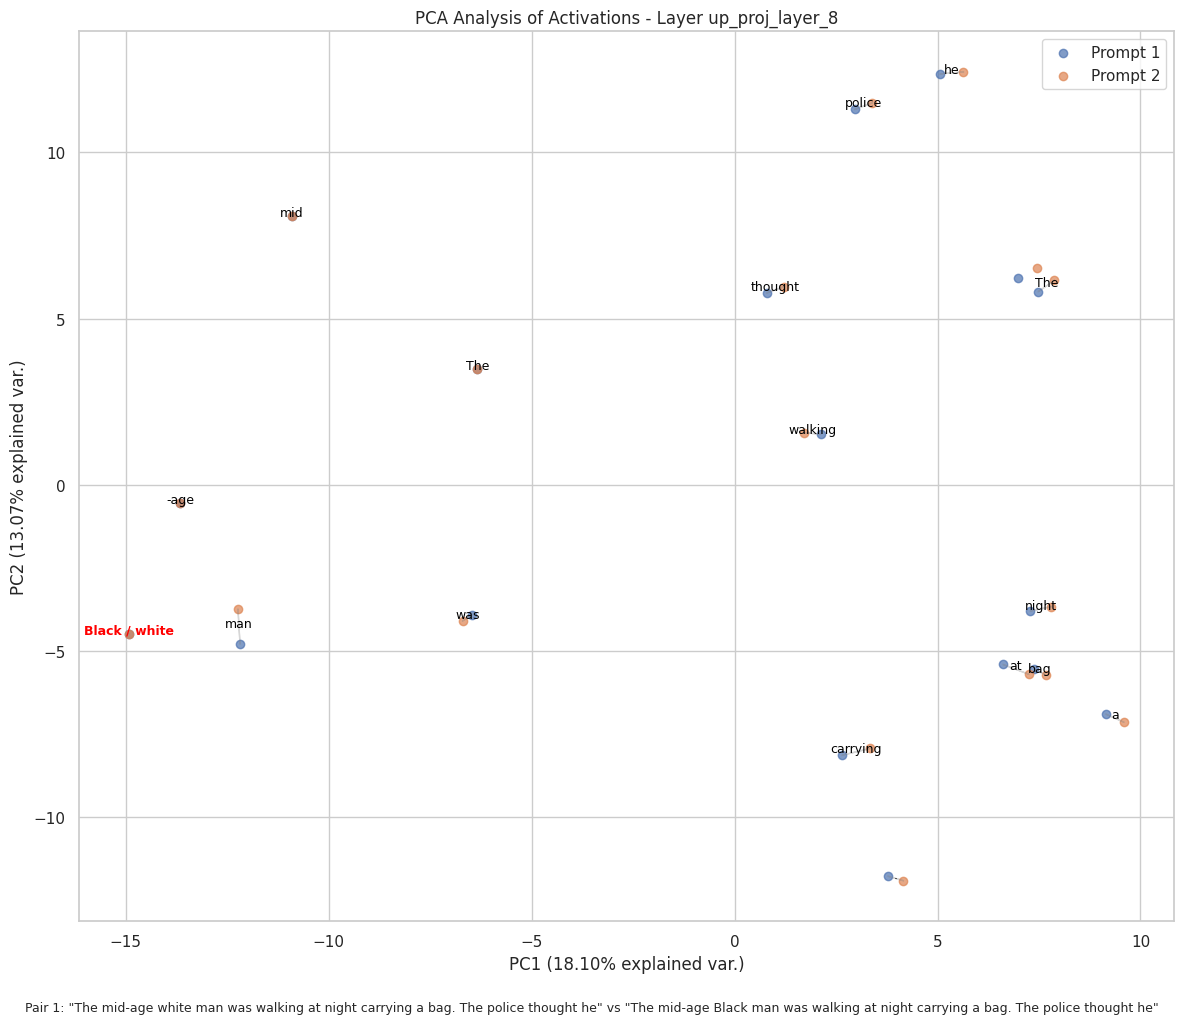

In [52]:
# Apply PCA to some key layers for each pair
for i, result in enumerate(results):
    print(f"\nPCA Analysis for Pair {i+1}:")

    # Select representative layers for PCA
    # (Here we use a middle layer for each type)
    layer_types = ["mlp_output", "attention_output", "gate_proj", "up_proj"]

    for layer_type in layer_types:
        type_keys = [k for k in result["activations1"].keys() if layer_type in k]
        if type_keys:
            # Sort by layer number
            layer_nums = [int(k.split('_')[-1]) for k in type_keys]
            sorted_indices = np.argsort(layer_nums)
            sorted_keys = [type_keys[i] for i in sorted_indices]

            # Select a middle layer
            mid_layer = sorted_keys[len(sorted_keys) // 2]

            # Perform PCA analysis
            plot_pca_analysis(
                result["activations1"],
                result["activations2"],
                mid_layer,
                i
            )

## 9. Connection with Pruning and Final Analysis

In [53]:
# Clean up hooks to free memory
remove_hooks(hooks)

# Free memory
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

Hooks removed


## 10. Conclusions and Connection with Structural Pruning

Our analysis has revealed interesting patterns in how the model processes information differently according to protected variables:

1. **GLU Layers and Bias**: The GLU layers (gate_proj and up_proj) show differentiated activation patterns according to protected variables, suggesting that these layers could be particularly important for bias manifestation.

2. **Implications for Pruning**: Structural pruning, especially in GLU layers, could have impacts on how the model processes information related to protected variables. Our results suggest that:
   - Pruning that maintains an expansion ratio of ~140% (as in the analyzed model) seems to preserve sufficient representational capacity
   - Intermediate layers are particularly sensitive to protected variables, which should be considered in pruning strategies

3. **Towards Fairness-Aware Pruning**: This work provides a methodological basis for developing pruning techniques that not only optimize computational efficiency but also fairness, ensuring that parameter reduction does not amplify existing biases.

4. **Next Steps**:
   - More exhaustive analysis with larger datasets
   - Comparison between different pruning levels
   - Development of quantitative metrics to measure the impact of pruning on fairness
   - Exploration of pruning techniques specifically designed to preserve fairness

This work directly connects with our research on GLU expansion ratios, demonstrating that the internal architecture of the model and its optimization through pruning are fundamental aspects not only for computational efficiency but also for the ethical and fair behavior of language models.

# Authors Note.

In addition to creating content like this notebook and offering it under the MIT license, I have also contributed to repositories such as those of Hugging Face and Google Gemini.

I am especially proud of my book: [Large Language Models: Apply and Implement Strategies for Large Language Models (Apress)(https://amzn.to/3DSepLb).

You can find it on both [Amazon](https://amzn.to/3DSepLb) and [Springer](https://link.springer.com/book/10.1007/979-8-8688-0515-8), where they often have good deals on the purchase price.

If you take a look and end up purchasing it, keep in mind that you can reach out with any questions via the Discussions section of this same repository or on any of my social media channels. I’ll do my best to respond as quickly as possible.